# Star Wars Retrieval-Augmented Generation (RAG) System

This Jupyter Notebook demonstrates a Retrieval-Augmented Generation (RAG) system designed to answer questions about the Star Wars universe. The system combines a retriever that fetches relevant documents from a knowledge base with a language model that generates answers based on these documents. The core components include embeddings for vector representations, a FAISS vector store for efficient retrieval, and a conversational retrieval chain.

## 0. Installation
Ensure you have the following libraries installed:


* `langchain`
* `faiss-gpu`
* `openai`

To install, uncomment the cell below

In [ ]:
!pip install -q transformers
!pip install -q "datasets<=2.18.0"
!pip install -q sentence-transformers
!pip install -q langchain
!pip install -q langchain_community
!pip install -q langchainhub
!pip install -q torch
!pip install -q faiss-gpu
!pip install -q "bitsandbytes<=0.40.2"

## 1. Import Statements
This section imports the necessary libraries:

* `OpenAI`: Interface for OpenAI's language models.
* `ConversationalRetrievalChain`: Combines LLM, retriever, and memory for conversational QA.
* `FAISS`: Library for efficient similarity search and clustering of dense vectors.
* `OpenAIEmbeddings`: Creates embeddings using OpenAI models.
* `ConversationBufferMemory`: Stores and manages conversation history.


In [ ]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.llms import HuggingFacePipeline
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.6/974.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.6/315.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

We are going to use the imdb dataset provided by huggingface. The dataset is easy to use and to load.

## 2. Load Data
The imdb datset comes with 3 seperate sets of data as can be seen above: train, test, and unsupervised. For our applicaiton we only want the text to give the LLM to train. It does not have to be labeled so we can treat the data as all unsupervised. We will combine all the data into a single dataset.

In [ ]:
from datasets import load_dataset

# List available datasets and configurations
imdb_dataset = load_dataset("imdb")

# Print available splits to ensure correct loading
print(imdb_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [ ]:
from datasets import concatenate_datasets

combined_dataset = concatenate_datasets([imdb_dataset['train'], imdb_dataset['test'], imdb_dataset['unsupervised']])

print(combined_dataset)

print(combined_dataset[0])

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered

We want to narrow down our dataset to just one topic. We decided for this project to make that topic Star Wars. There are in total 9 movies: 3 classic movies, 3 movies from the early 2000s and 3 recent movies.

In [ ]:
import re

# Define the movie you want to filter by
specific_movie = "Star Wars"

# Define a function to filter texts containing the specific word or phrase
def filter_texts(example):
    return bool(re.search(rf'\b{specific_movie}\b', example['text'], re.IGNORECASE))

# Apply the filter to the combined dataset
filtered_dataset = combined_dataset.filter(filter_texts)

# Verify the filtered dataset
print(filtered_dataset)

print(filtered_dataset[0])

Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 618
})
{'text': 'As a kid I did think the weapon the murderer wielded was cool, however I was a kid and so I was a bit dumb. Even as a dumb kid though the movies plot was stupid and a bit boring when the killer was not using his light knife to kill people. What amazes me is that the movie has a really solid cast in it. What script did they read when agreeing to be in this movie as it is most assuredly boring and only a means to show off a light saber on a very small scale. The plot at times is incomprehensible and the end is totally chaotic. The whole film seems to rotate around aliens and the one weapon. The plot has two kids and some dude having an alien encounter, flash years later and there seems to be a return as it were in the mix. Dead animals and such to be explored and for some reason the one dude gets the weapon of the aliens and proceeds to use it to go on a very light killing spree. Seriously, you just have to wonder 

As mentioned above the domain for our project is Star Wars. Star Wars is now a large universe with movies, television shows, theme park rides, books, comics, and toys. It was originally 3 movies that redefinded the genre of science fiction movies, and was the introduction of modern special effects.

The dataset we are using is the IMDB dataset provided by huggingface. Considering the dataset is limited to movie reviews, the rest of the Star Wars universe is excluded except for the 9 movies. The 9 movies vary in age. It is plausible that the older movies have more reviews and will provide better context for LLM.

Dataset profiling with a summary of through descriptive statistics can be found below:

In [ ]:
import pandas as pd

df = pd.DataFrame(filtered_dataset)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())

# Basic Statistics for Numerical Columns
print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe())

# Frequency Counts for Categorical Columns
print("\nFrequency Counts for 'label' Column:")
print(df['label'].value_counts())

# Check for Missing Values
print("\nMissing Values Summary:")
print(df.isnull().sum())

# Custom Function to Summarize Text Data Lengths
def text_length_summary(df, column):
    text_lengths = df[column].apply(len)
    print(f"\nText Length Summary for '{column}':")
    print(f"Count: {len(text_lengths)}")
    print(f"Mean: {text_lengths.mean()}")
    print(f"Median: {text_lengths.median()}")
    print(f"Min: {text_lengths.min()}")
    print(f"Max: {text_lengths.max()}")
    print(f"Standard Deviation: {text_lengths.std()}")
    print(f"Quantiles:  {text_lengths.quantile([0.25, 0.5, 0.75])}")
    print(f"Variance:  {text_lengths.var()}")
    print(f"Skewness:  {text_lengths.skew()}")
    print(f"Kurtosis:  {text_lengths.kurt()}")

# Apply the Text Length Summary Function
text_length_summary(df, 'text')

Dataset Preview:
                                                text  label
0  As a kid I did think the weapon the murderer w...      0
1  I have just lost three hours of my life to thi...      0
2  Well, on it's credit side (if it can be said t...      0
3  Anyone who has a remote interest in science fi...      0
4  I can't believe this movie managed to get such...      0

Descriptive Statistics for Numerical Columns:
            label
count  618.000000
mean    -0.237864
std      0.834851
min     -1.000000
25%     -1.000000
50%      0.000000
75%      1.000000
max      1.000000

Frequency Counts for 'label' Column:
label
-1    306
 1    159
 0    153
Name: count, dtype: int64

Missing Values Summary:
text     0
label    0
dtype: int64

Text Length Summary for 'text':
Count: 618
Mean: 1934.7459546925566
Median: 1461.5
Min: 246
Max: 9420
Standard Deviation: 1382.7775369001813
Quantiles:  0.25     926.25
0.50    1461.50
0.75    2447.50
Name: text, dtype: float64
Variance:  1912073.716555

Counter({'the': 10958, 'of': 5415, 'a': 5218, 'and': 5088, 'to': 4465, 'is': 3252, 'in': 2972, 'that': 2368, 'I': 2130, '/><br': 1994, 'it': 1817, 'this': 1780, 'was': 1579, 'as': 1530, 'with': 1405, 'for': 1388, 'The': 1339, 'but': 1121, 'are': 1096, 'on': 1027, 'movie': 958, 'have': 950, 'be': 926, 'not': 868, 'you': 860, 'film': 837, 'like': 805, 'from': 791, 'one': 755, 'they': 749, 'his': 725, 'at': 724, 'all': 717, 'by': 704, 'Star': 680, 'or': 637, 'an': 626, 'he': 606, 'has': 561, 'so': 557, 'who': 550, 'just': 548, 'about': 522, 'more': 495, 'out': 494, 'some': 491, 'can': 461, 'Wars': 448, 'even': 433, 'if': 421, "it's": 420, 'were': 419, 'good': 414, 'what': 405, 'than': 401, 'when': 400, 'very': 390, 'would': 377, 'up': 375, 'only': 374, 'This': 369, 'which': 366, 'It': 365, 'no': 363, 'my': 358, 'their': 358, 'had': 348, 'really': 343, 'into': 339, 'there': 335, 'most': 333, 'its': 328, 'will': 323, '-': 322, 'other': 312, 'see': 310, 'first': 307, 'get': 297, 'been': 293,

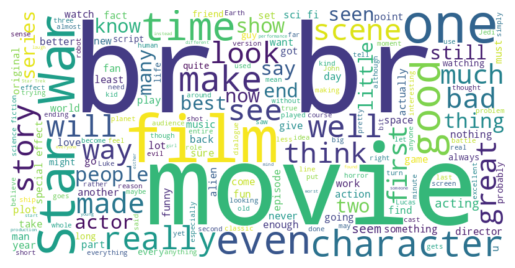

In [ ]:
from collections import Counter
from wordcloud import WordCloud

# Word Count Analysis
all_text = " ".join(df['text'])
word_counts = Counter(all_text.split())
print(word_counts)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Embeddings
We utilize `LangChain` to use with our sentence embeddings. Sentence embeddings are fixed-size vector representations of sentences. These vectors capture the semantic meaning of sentences. LangChain simplifies the process of generating and utilizing sentence embeddings by providing seamless integration with pre-trained language models and embedding models. We chose LangChain for its flexabilty working with different LLMs and different vector stores.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 100,
    length_function = len,
    is_separator_regex=False,
    # separators=[
    #     "\n\n",
    #     ".",
    #     "\n",
    #     " ",
    #     "",
    # ]
)

# Extract texts from the dataset
text = filtered_dataset["text"]

# Concatenate all texts into a single string
concatenated_text = " ".join(text)

texts = text_splitter.create_documents([concatenated_text])

print(texts[:2])

[Document(page_content='As a kid I did think the weapon the murderer wielded was cool, however I was a kid and so I was a bit dumb. Even as a dumb kid though the movies plot was stupid and a bit boring when the killer was not using his light knife to kill people. What amazes me is that the movie has a really solid cast in it. What script did they read when agreeing to be in this movie as it is most assuredly boring and only a means to show off a light saber on a very small scale. The plot at times is incomprehensible and the end is totally chaotic. The whole film seems to rotate around aliens and the one weapon. The plot has two kids and some dude having an alien encounter, flash years later and there seems to be a return as it were in the mix. Dead animals and such to be explored and for some reason the one dude gets the weapon of the aliens and proceeds to use it to go on a very light killing spree. Seriously, you just have to wonder why this movie was made, if you are going to have 

## 4. Vector Store

We are using `FAISS` (Facebook AI Similarity Search) for efficient similarity search and clustering of dense vectors. FAISS serves as a vector store for managing and querying the high-dimensional embeddings of our textual data. We chose FAISS for its speed, flexibility and high performance.


In [ ]:
from langchain.embeddings import CacheBackedEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

store = LocalFileStore("./cache/")

embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

core_embeddings_model = HuggingFaceEmbeddings(
    model_name=embed_model_id
)

embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

vector_store = FAISS.from_documents(texts, embedder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5. Prompt Engineering



In [ ]:
query = "What is Star Wars?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

be any actual emphasis on plot, it just being an excuse to glue one over-long action set piece to another, so the intrigue disappears fast and the themes and contexts are given a back seat to (admittedly impressive) CGI. It seems that George Lucas thought that what made a good film was as much soulless eye candy as possible.<br /><br />Star wars was once a trailblazer in Science fiction and its originality gave most of the future Blockbusters the templates for their scenes, and what was originally Star Wars innovation became cliché at the hands of other films. Now it is Star Wars using the same plot lines we have seen over and over again, copying others and Episodes 1, 2 and 3 in a lazy attempt to seem interesting.<br /><br />You do not need spectacle to create a good film you need drama and humanity both of which this film sorely lacks. In my opinion the best Light Sabre Fight of the series was the Showdown between Darth Vader and Obi-Wan Kenobi. The fight didn't have any flipping or


In [ ]:
query = "Who is darth vader?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

to working alongside the Rebels to destroy an all new Death Star that nears completion. This time the Emperor himself is overseeing the final stages of construction. The Empire intends to crush the Rebellion once and for all, while the Emperor himself schemes to bring the now powerful Skywalker to his side to work alongside (or is that replace?) Darth Vader. The Emperor is a different kind of evil for this film, less cunning than Governor Tarkin (Peter Cushing) from "Star Wars", more deeply psychologically dark than anything else. Played brilliantly by Ian McDiarmid, the Emperor is just one of those characters you love to hate.<br /><br />All the other actors are well entrenched in their roles. Hamill surprises as the more wisened Luke, making his character's progression from whiny teenager, impatient student to enlightened warrior one of the few real character developments of the series. Ford's role is waring thin, as all his charm and charisma was spent in the first two films -- he
a

In [ ]:
query = "Who is luke skywalker's father?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

is that Yoda is too old and sick, since he already has 900 years old, and before he dies, Yoda says to Luke that he does not need more training,but to really be a Jedi, he must fight with Vader again. He confirms to Luke that Vader is Luke's dad, and that there is another Skywalker besides Luke. In his last moments, Yoda asks to Luke to remember his advices about the temptation of the dark side, and to Luke transmit his Jedi knowledge to other people. When Yoda dies,Obi wan's spirit shows up to Luke and tells him that Luke's father killed his good side Anakin to become Darth Vader, and also that he is more machine than a man since he became a sith. Luke stays worried about killing his own dad, and says that he feels that his father still has kindness. Obi Wan tells Luke that his twin sister is Leia, and says the reasons why Luke and Leia were separated since babies. He gives his last advice to Luke saying that if he refuses to kill Vader, the emperor will win the war.<br /><br />At
Fat

In [ ]:
query = "Why were the sequals worse than the originals or the prequals?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

innovative for it's time, and that it has been copied very often, but maybe that's exactly why the whole thing sometimes seems a little below it's reputation. There are tough, rebellious youths and pink-haired squeaky cute computer geniuses all over the place on the anime market. The fact that they're all female is hardly a novelty anymore either.<br /><br />That might be the main problem here; time hasn't been too kind to Bubblegum Crisis. Those who first saw the series and became loyal followers in the 80's had every reason to be impressed back then. Alas, by now, the same formula has appeared so often, be it under different guises, that there's little left to be amazed about for one watching this series for the first time now. Somehow BGC doesn't really manage to hold up a feeling that it's the founding father of a whole generation of anime series.<br /><br />Animation quality has aged a bit better though, with only the first episode looking genuinely old hat by now. Episodes seven


In [ ]:
query = "Were the prequals worse than the orginals?"
embedding_vector = core_embeddings_model.embed_query(query)
docs = vector_store.similarity_search_by_vector(embedding_vector, k = 4)

for page in docs:
  print(page.page_content)

calculator once. I'm never quite sure whether the Cylons had an organic counterpart who created them, but it doesn't really matter.<br /><br />In many ways this show is a shallow imitation of "Star Wars," and this can be seen in the cast of characters. Particularly Starbuck (Dirk Benedict), who tries so hard to be Han Solo, but only comes off as petulant, sexist, and rather pathetic. Apollo is the noble, Luke Skywalker hero type, and as such doesn't have a personality. Starbuck has a faithful black sidekick, Boomer, who seems to be much more competent than Starbuck. Adama also has a faithful black sidekick, called Colonel Tigh, who at one point is reduced to picking up everyone's laundry. Take that, Civil Rights Movement!<br /><br />The destruction of the human colonies is a brief, and amazingly painless affair. A park is strafed by Cylon ships, and a small dog is killed (though the actual death is not shown, so we are left with some hope). Soon enough, our heroes have forgotten all
US

## 6. LLM Quantization

We choose to use GPT-2 from OpenAI as our pre-trained model. GPT-2 is a transformer-based model with 1.5 billion parameters, designed to predict the next word in a sentence, trained on a diverse dataset of internet text. There are other free LLMs to choose from and were considered, such as orca, lamma2,and tiny-bert, but we found GPT-2 integrates well with HuggingFace. We ultimately chose GPT-2 for this project.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load pre-trained model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding=True, truncation=True, max_length=100)
model = GPT2LMHeadModel.from_pretrained(model_name)

model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
from langchain.llms.huggingface_pipeline import HuggingFacePipeline
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import BitsAndBytesConfig

# Set the padding token to the EOS token
tokenizer.pad_token = tokenizer.eos_token

# Creating retriever from the vectorstore with a search configuration where it retrieves up to 4 relevant splits/documents.
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

# Define a question-answering pipeline using the model and tokenizer
question_answerer = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024,
    num_beams=2,
    num_return_sequences=1,
    top_k=50,
    top_p=1.0,
    temperature=0.7,
    do_sample=True
)

llm = HuggingFacePipeline(
    pipeline=question_answerer,
    model_kwargs={"temperature": 0.7, "max_length": 100},
)

from langchain.chains import RetrievalQA
from langchain import hub

# Loads the latest version of the RAG prompt
prompt = hub.pull("rlm/rag-prompt", api_url="https://api.hub.langchain.com")

qa_chain = RetrievalQA.from_chain_type(
    llm, retriever=retriever, chain_type_kwargs={"prompt": prompt}, chain_type="stuff"
)


Test our model with a simple query.

In [ ]:
question1 = "What is Star Wars?"
result1 = qa_chain.run({"query": question1})
print(result1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: What is Star Wars? 
Context: be any actual emphasis on plot, it just being an excuse to glue one over-long action set piece to another, so the intrigue disappears fast and the themes and contexts are given a back seat to (admittedly impressive) CGI. It seems that George Lucas thought that what made a good film was as much soulless eye candy as possible.<br /><br />Star wars was once a trailblazer in Science fiction and its originality gave most of the future Blockbusters the templates for their scenes, and what was originally Star Wars innovation became cliché at the hands of other films. Now it is Star Wars using the same plot lines we have seen over and over again, copying others and Episodes 1, 2 and 3 in a lazy attempt to seem inte

We had an idea to add a history to the chat-bot so it could understand the context of previous prompts and give an even better answer but we could never get it to run correctly. We leave the code but we no longer try to use the functions. The problems we found with trying to use history was that it added too many characters to the queries.

In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

chat_qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [ ]:
question3 = "Who is Darth Vader?"
result3 = qa_chain.run({"query": question3})
print(result3)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: Who is Darth Vader? 
Context: to working alongside the Rebels to destroy an all new Death Star that nears completion. This time the Emperor himself is overseeing the final stages of construction. The Empire intends to crush the Rebellion once and for all, while the Emperor himself schemes to bring the now powerful Skywalker to his side to work alongside (or is that replace?) Darth Vader. The Emperor is a different kind of evil for this film, less cunning than Governor Tarkin (Peter Cushing) from "Star Wars", more deeply psychologically dark than anything else. Played brilliantly by Ian McDiarmid, the Emperor is just one of those characters you love to hate.<br /><br />All the other actors are well entrenched in their roles. Hamill surp

In [ ]:
question4 = "Who is luke skywalker's father?"
result4 = qa_chain.run({"query": question4})
print(result4)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: Who is luke skywalker's father? 
Context: is that Yoda is too old and sick, since he already has 900 years old, and before he dies, Yoda says to Luke that he does not need more training,but to really be a Jedi, he must fight with Vader again. He confirms to Luke that Vader is Luke's dad, and that there is another Skywalker besides Luke. In his last moments, Yoda asks to Luke to remember his advices about the temptation of the dark side, and to Luke transmit his Jedi knowledge to other people. When Yoda dies,Obi wan's spirit shows up to Luke and tells him that Luke's father killed his good side Anakin to become Darth Vader, and also that he is more machine than a man since he became a sith. Luke stays worried about killing his own dad, 

In [ ]:
question5 = "Why were the sequals worse than the originals or the prequals?"
result5 = qa_chain.run({"query": question5})
print(result5)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: Who is luke skywalker's father? 
Context: is that Yoda is too old and sick, since he already has 900 years old, and before he dies, Yoda says to Luke that he does not need more training,but to really be a Jedi, he must fight with Vader again. He confirms to Luke that Vader is Luke's dad, and that there is another Skywalker besides Luke. In his last moments, Yoda asks to Luke to remember his advices about the temptation of the dark side, and to Luke transmit his Jedi knowledge to other people. When Yoda dies,Obi wan's spirit shows up to Luke and tells him that Luke's father killed his good side Anakin to become Darth Vader, and also that he is more machine than a man since he became a sith. Luke stays worried about killing his own dad, 

In [ ]:
question6 = "Were the prequals worse than the orginals?"
result6 = qa_chain.run({"query": question6})
print(result6)

Human: You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: Were the prequals worse than the orginals? 
Context: calculator once. I'm never quite sure whether the Cylons had an organic counterpart who created them, but it doesn't really matter.<br /><br />In many ways this show is a shallow imitation of "Star Wars," and this can be seen in the cast of characters. Particularly Starbuck (Dirk Benedict), who tries so hard to be Han Solo, but only comes off as petulant, sexist, and rather pathetic. Apollo is the noble, Luke Skywalker hero type, and as such doesn't have a personality. Starbuck has a faithful black sidekick, Boomer, who seems to be much more competent than Starbuck. Adama also has a faithful black sidekick, called Colonel Tigh, who at one point is reduced to picking up everyone's lau

## 7. Human-based Qualitative Evaluation

